In [1]:
from utils import *
import pandas as pd
import json
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, mannwhitneyu, hmean
import random
import os
import pickle
import json
import glob


import warnings
warnings.filterwarnings('ignore')

In [2]:
random.seed(13)

# some parameters for plotting style

empty_hist={"histtype": "step", "linewidth": 1,
                            "alpha": 1}

colors={
    'RT1': "#e74c3c",
    'RT2': "#9b59b6",
    'RT3': "#2ecc71",
    'RT4':"#f4d03f",
    'RT5': "#3498db",
}

In [3]:
with open('resources/partition.json','rb') as fi:
    partition=json.load(fi) #loads the community partition obtained through Louvain and explored in previous paper

com_dict={0:'RT1',5:'RT2',7:'RT3',4:'RT4',2:'RT5'} # naming

subpart={k:com_dict[v] for k,v in partition.items() if v in com_dict.keys()} # users in the top 5 communities


In [4]:
#let's create a randomisation of the community structure; will come in handy later as a random baseline

random.seed(13)
vals=[x for x in subpart.values()]
rnd_vals= random.sample(vals, len(vals))     

orig_keys=[x for x in subpart.keys()]
reshuffled_subpart={k:v for k,v in zip(orig_keys,rnd_vals)}

In [5]:
# loads the number of tweets per users with (un)reliable content in the dataset. From get_stats.py

with open('resources/user_quantities.dict','rb') as fi:
    inputdict=pickle.load(fi) 
inputdict={k:v for k,v in inputdict.items() if v['num_rel']!=0 or v['num_unrel']!=0}

In [6]:
# load user quantities in pandas dataframe and compute Untrustworthiness index

user_stats=u_index(inputdict, subpart, reshuffled_subpart) # function from utils.py
user_stats.head()

,user_id,top5community,rnd_community,num_rel,num_unrel,num_lost,tweets,tweets_norm,linear_fs,harm_fs,norm_harm_fs
0,16986506,RT1,RT1,44,0,382,44,0.001276,0.0,0.000186,0.000187
1,808943853394857984,RT1,RT3,151,0,1997,151,0.004379,0.0,0.000196,0.000196
2,46928097,RT1,RT2,1,0,6803,1,0.000029,0.0,0.000113,0.000113
3,150725695,RT5,RT1,208,0,29844,208,0.006031,0.0,0.000197,0.000197
4,939431707878490113,RT1,RT2,1,0,37,1,0.000029,0.0,0.000113,0.000113


In [7]:
user_stats['user_id'] = user_stats['user_id'].astype(str)

In [8]:
user_stats.to_csv('outputs/user_stats.csv', index=False)

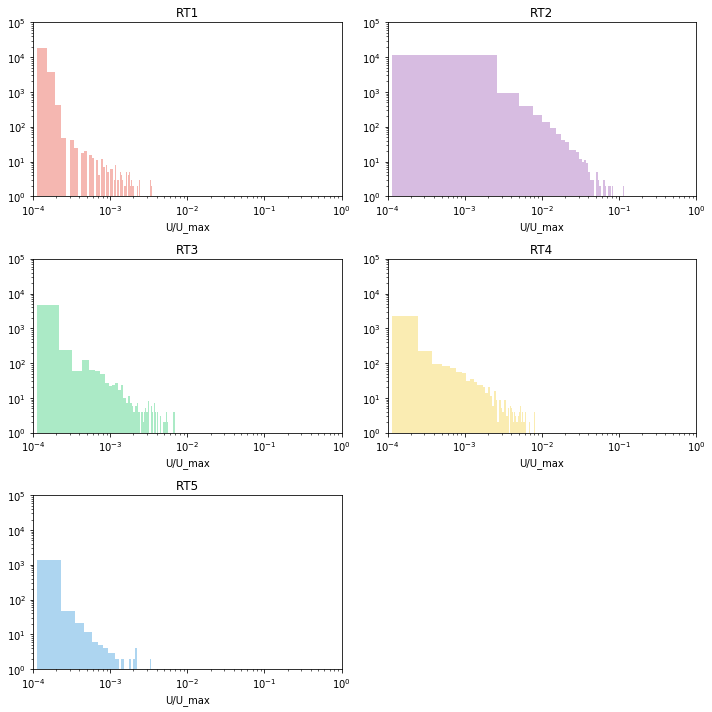

In [9]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10,10), sharey='row')

i=1 
for v in sorted(com_dict.values()):
    ax = plt.subplot(3, 2, i)
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_ylim(10**0,10**5)
    ax.set_xlim(10**(-4),10**0)
    sub_top5intersec=user_stats[user_stats['top5community']==v]
    sns.distplot(sub_top5intersec.norm_harm_fs, color=colors[v], ax=ax, kde=False,bins=400)    
    ax.set_title(v)
    ax.set_xlabel('U/U_max')
      
    i+=1
plt.subplots_adjust(hspace=0.5)
ax = plt.subplot(3, 2, 6)
ax.axis('off')
plt.tight_layout()
plt.show()

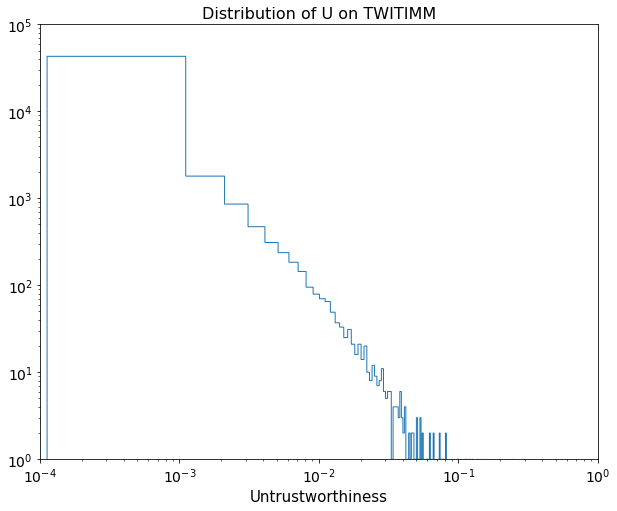

In [10]:
fig,ax=plt.subplots(figsize=(10,8))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(10**0,10**5)
ax.set_xlim(10**(-4),10**0)
sns.distplot(user_stats.harm_fs, bins=1000,hist_kws=empty_hist, kde=False, ax=ax)
ax.set_title('Distribution of U on TWITIMM',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Untrustworthiness', fontsize=15)

plt.show()

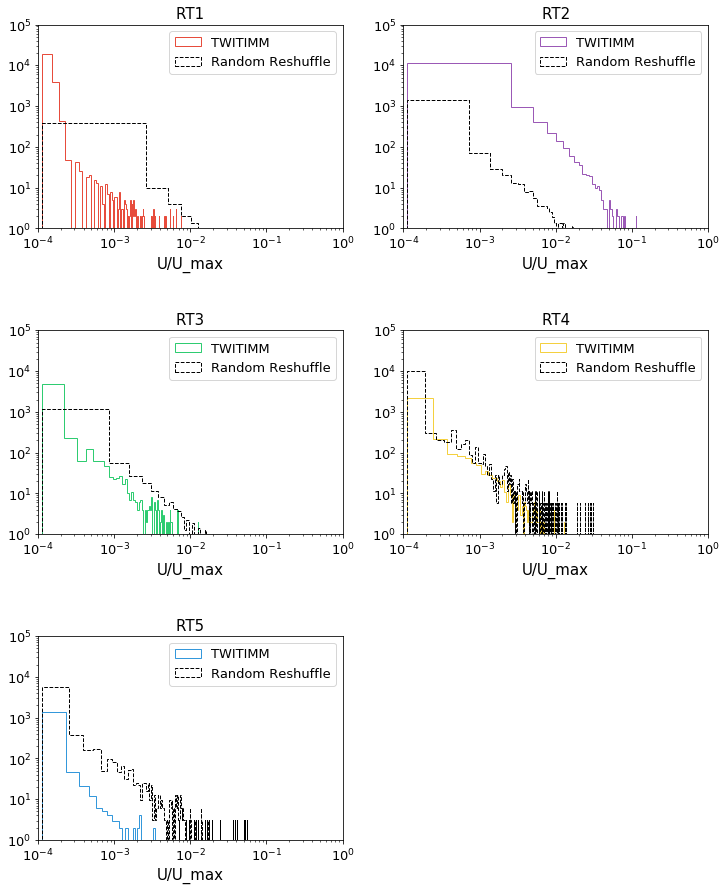

In [11]:
#let's check the distribution of U against a randomisation of the community structure

kws={'histtype': 'step',
 'linewidth': 1,
 'alpha': 1,
 'density': True,
 'label': 'random reshuffle',
 'linestyle': 'dashed'}


fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (12,15), sharey='col')

i=1
for v in com_dict.values():
    ax = plt.subplot(3, 2, i)
    ax.set_yscale('log')
    #ax.set_xlim(0,0.5)
    ax.set_xscale('log')
    ax.set_ylim(10**0,10**5)
    ax.set_xlim(10**(-4),10**0)
    sub_top5=user_stats[user_stats['top5community']==v]
    rand_sub_top5=user_stats[user_stats['rnd_community']==v]
    sns.distplot(sub_top5.harm_fs, hist_kws=empty_hist, label='TWITIMM', ax=ax, kde=False, color=colors[v],bins=400)    
    sns.distplot(rand_sub_top5.harm_fs, hist_kws=kws,label='Random Reshuffle', ax=ax, kde=False, color='k',bins=400)    
    ax.set_title(v,fontsize=15)
    ax.set_xlabel('U/U_max', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.legend(fontsize=13)
    i+=1
plt.subplots_adjust(hspace=0.5)
ax = plt.subplot(3, 2, 6)
ax.axis('off')
plt.show()

# Botometer

Let's now load and analyse the results of Botometer. 

We will now load the BotScore of the users in the TWITIMM dataset and that of the users in random sample from TWITA, equal in size and temporal distribution (i.e., number of unique users per day over a year).

Important: for the validation of the results, check the notebook __botometer_validation.ipynb__

## TWITIMM

In [12]:
results={}
for j in os.listdir('data/botometer_results'):
    with open('data/botometer_results/{}'.format(j),'r') as fi:
        res=json.load(fi)
        results.update(res)
        
print('Number of users analysed: {}'.format(len(results)))

Number of users analysed: 197628


In [13]:
# botometer error management

notfound=[x for x in list(results.keys()) if 'error' in results[x].keys()]
errors=[results[x]['error'] for x in notfound]
not_sendrequest=[x for x in set(errors) if x.startswith('TweepError: Failed to send request') or x.startswith('TweepError: Twitter error response:')] 

results_noerror={k:results[k] for k in set(results.keys())-set(notfound)}

with open('outputs/botometer_results_noerrors.dict','wb') as fo:
    pickle.dump(results_noerror, fo)

print('Number of users correctly retrieved: {}'.format(len(results_noerror)))


Number of users correctly retrieved: 169604


In [14]:
#every user is assigned a botscore
results_global={k:v for k,v in results.items() if k in subpart.keys()}

with open('outputs/results.dict','wb') as fo:
    pickle.dump(results_global,fo)

In [15]:
#let's build a pandas df with all the BotScore statistics for the TWITIMM users

astroturf_glob=[results_global[x]['raw_scores']['universal']['astroturf'] for x in set(results_global.keys())-set(notfound)]
fake_follower_glob=[results_global[x]['raw_scores']['universal']['fake_follower'] for x in set(results_global.keys())-set(notfound)]
spammer_glob=[results_global[x]['raw_scores']['universal']['spammer'] for x in set(results_global.keys())-set(notfound)]
overall_glob=[results_global[x]['raw_scores']['universal']['overall'] for x in set(results_global.keys())-set(notfound)]
cap_glob=[results_global[x]['cap']['universal'] for x in set(results_global.keys())-set(notfound)]
user_glob=[k for k in set(results_global.keys())-set(notfound)]

df_glob=pd.DataFrame()
df_glob['user_id']=user_glob
df_glob['top5community']=df_glob.user_id.map(subpart)
df_glob['cap']=cap_glob
df_glob['overall']=overall_glob
df_glob['fakefollower']=fake_follower_glob
df_glob['spammer']=spammer_glob
df_glob['astroturf']=astroturf_glob
df_glob['rnd_community']=df_glob.user_id.map(reshuffled_subpart) #info on random community
df_glob.to_csv('outputs/df_glob.csv',index=False)

df_glob.head()

,user_id,top5community,cap,overall,fakefollower,spammer,astroturf,rnd_community
0,2762281706,RT1,0.494491,0.10,0.05,0.04,0.02,RT1
1,289213386,RT4,0.436508,0.08,0.08,0.01,0.13,RT1
2,970856136,RT1,0.810213,0.75,0.27,0.13,0.07,RT2
3,1107646352627060737,RT2,0.794711,0.33,0.33,0.19,0.08,RT1
4,886706561330155521,RT1,0.778449,0.28,0.53,0.08,0.04,RT1


## Twita random sample

In [16]:
rand_results={}
for j in os.listdir('data/botometer_results_random_twita'):
    try:
        with open('data/botometer_results_random_twita/{}'.format(j),'r') as fi:
            res=json.load(fi)
            rand_results.update(res)
    except IsADirectoryError:
        continue
    
#missing users were retrieved at a later stage to match the size of the TWITIMM dataset:
addictional_files = glob.glob('data/botometer_results_random_twita/aws/**/*.json', recursive=True)


for f in addictional_files:
    with open(f,'r') as fi:
        res=json.load(fi)
        rand_results.update(res)
        
# botometer error management
rand_notfound=[x for x in list(rand_results.keys()) if 'error' in rand_results[x].keys()]

rand_results_noerror={k:rand_results[k] for k in set(rand_results.keys())-set(rand_notfound)}


In [17]:
#let's build a pandas df with all the BotScore statistics for the random sample

astroturf=[rand_results_noerror[x]['raw_scores']['universal']['astroturf'] for x in rand_results_noerror]
fake_follower=[rand_results_noerror[x]['raw_scores']['universal']['fake_follower'] for x in rand_results_noerror]
spammer=[rand_results_noerror[x]['raw_scores']['universal']['spammer'] for x in rand_results_noerror]
overall=[rand_results_noerror[x]['raw_scores']['universal']['overall'] for x in rand_results_noerror]
cap=[rand_results_noerror[x]['cap']['universal'] for x in rand_results_noerror]
user=[k for k in rand_results_noerror]

rand_df=pd.DataFrame()
rand_df['user_id']=user
rand_df['cap']=cap
rand_df['overall']=overall
rand_df['fakefollower']=fake_follower
rand_df['spammer']=spammer
rand_df['astroturf']=astroturf

rand_df.head()

,user_id,cap,overall,fakefollower,spammer,astroturf
0,309849803,0.376790,0.06,0.01,0.01,0.09
1,218987917,0.260368,0.02,0.02,0.01,0.00
2,768739622448992256,0.678486,0.18,0.05,0.01,0.09
3,707671864,0.811509,0.76,0.76,0.48,0.00
4,3092183615,0.837213,0.85,0.37,0.08,0.05


## Comparison

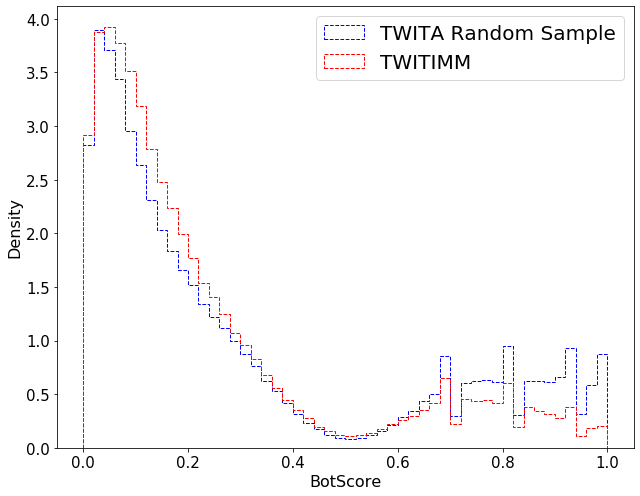

In [18]:
kws={'histtype': 'step',
 'linewidth': 1,
 'alpha': 1,
 'density': True,
 'label': 'random reshuffle',
 'linestyle': 'dashed'}


fig, ax=plt.subplots(figsize=(9,7))

sns.distplot(rand_df.overall,ax=ax,label='TWITA Random Sample',bins=50,kde=False, norm_hist=True, hist_kws=kws, color='b')
sns.distplot(df_glob.overall, ax=ax, label='TWITIMM', bins=50, kde=False, norm_hist=True,hist_kws=kws, color='r')
ax.legend(fontsize=20)
ax.set_xlabel('BotScore',fontsize=16)
ax.set_ylabel('Density',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

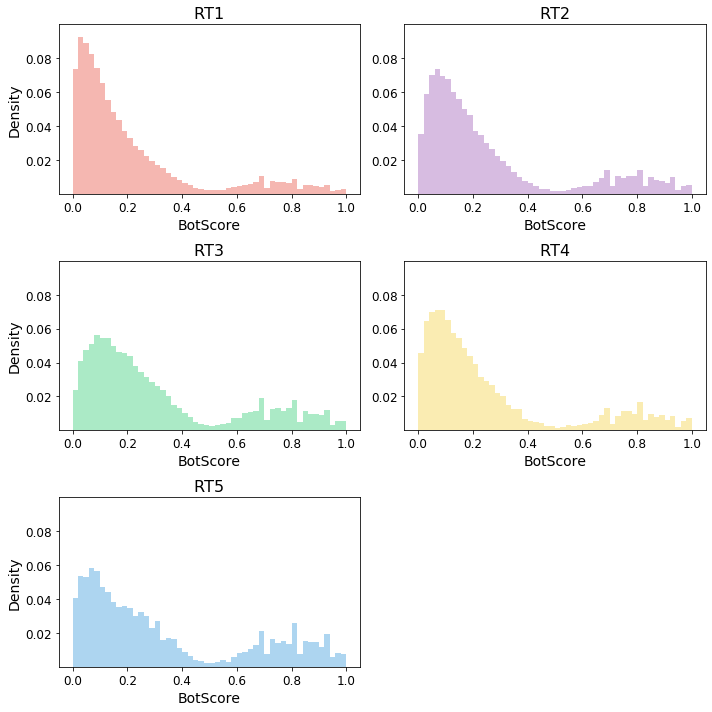

In [19]:
# TWITIMM BotScore disaggregated by community

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10,10), sharey=True)

i=1
bins=50
for v in com_dict.values():
    ax = plt.subplot(3, 2, i)
    #ax.set_yscale('log')
    ax.set_ylim(0,5)
    sub_top5=df_glob[df_glob['top5community']==v]
    sns.distplot(sub_top5.overall, color=colors[v], ax=ax, kde=False,norm_hist=True, bins=bins)
    
    #if norm_hist==True, sns.distplot yelds a normalised hist so that the area==1. Threrefore on y axis 
    #we have y=count/(total count * bin width)

    ax.set_title(v, fontsize=16)
    ax.set_xlabel('BotScore',fontsize=14)
    if i%2!=0:
        ax.set_ylabel('Density',fontsize=14)
        
    ax.set_yticks(np.arange(1,5))
    ax.set_yticklabels(np.arange(1,5)*(1/bins)) #bin width * y (to get count/total count)
    #warning! it varies based on y (i.e., on the number of bins)
    ax.tick_params(axis='both', which='major', labelsize=12)

    i+=1
plt.subplots_adjust(hspace=0.5)
ax = plt.subplot(3, 2, 6)
ax.axis('off')
plt.tight_layout()
plt.show()

### Check community distribution against randomisation of the community structure

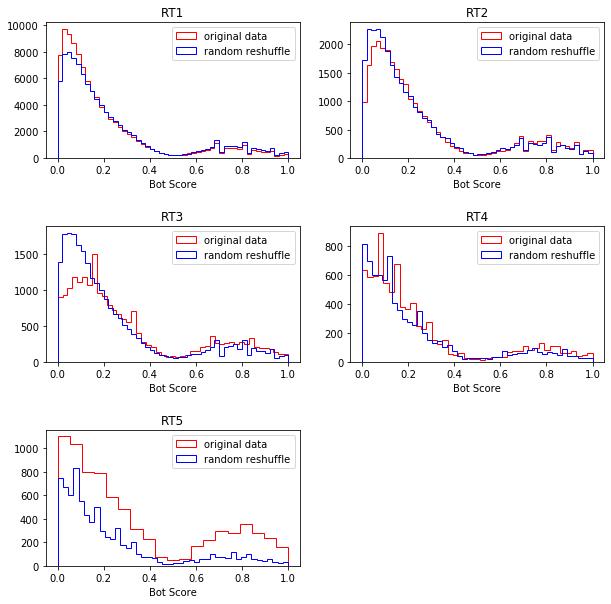

In [20]:
#let's see the results compared

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10,10), sharey='col')

i=1
for v in com_dict.values():
    ax = plt.subplot(3, 2, i)
    sub_top5=df_glob[df_glob['top5community']==v]
    rand_sub_top5=df_glob[df_glob['rnd_community']==v]
    sns.distplot(sub_top5.overall, hist_kws=empty_hist, label='original data', ax=ax, kde=False, color='r')    
    sns.distplot(rand_sub_top5.overall, hist_kws=empty_hist, label='random reshuffle', ax=ax, kde=False, color='b')    
    ax.set_title(v)
    ax.set_xlabel('Bot Score')
    ax.legend()
    i+=1
plt.subplots_adjust(hspace=0.5)
ax = plt.subplot(3, 2, 6)
ax.axis('off')
plt.show()

In [21]:
#a quick check with Mann-Whitney to assess significance

rand_scores={}
scores={}
for v in com_dict.values():
    sub_top5_rand=df_glob[df_glob['rnd_community']==v]
    rand_scores[v]=sub_top5_rand['overall'].tolist()
    
    sub_top5=df_glob[df_glob['top5community']==v]
    scores[v]=sub_top5['overall'].tolist()
    
for v in com_dict.values():
    print('{}:{}'.format(v, mannwhitneyu(rand_scores[v],scores[v],alternative='two-sided')))

RT1:MannwhitneyuResult(statistic=5642973215.0, pvalue=5.856616097912152e-188)
RT2:MannwhitneyuResult(statistic=382031505.0, pvalue=4.615998500858597e-43)
RT3:MannwhitneyuResult(statistic=202914086.5, pvalue=6.515976965513715e-273)
RT4:MannwhitneyuResult(statistic=32192332.0, pvalue=8.978861129104242e-13)
RT5:MannwhitneyuResult(statistic=24112438.0, pvalue=1.625094110560954e-92)
